# Demo notebook of [pytorch-tabnet](https://github.com/dreamquark-ai/tabnet) library on [Rossman Sales Dataset](https://www.kaggle.com/c/rossmann-store-sales/)

Useful links:
- [Original paper](https://arxiv.org/pdf/1908.07442.pdf)
- [Explanatory interview with core pytorch-tabnet contributor](https://youtu.be/ysBaZO8YmX8)

Author: Roman Burakov

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.metrics import Metric

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error as mae
from sklearn.manifold import TSNE

from collections import defaultdict

import torch

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data
data = pd.read_csv('./data/train.csv', parse_dates=['Date'])
store_features = pd.read_csv('./data/store.csv')

# Drop noisy data and leave only main features + add Month
data = data.loc[data.Open.eq(1) & ~data.Customers.eq(0) & ~data.Sales.eq(0)].drop(columns=['Customers', 'Open'])
store_features = store_features[['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2']]
data = data.merge(store_features, how='left').dropna()
data['Month'] = data.Date.dt.month

data.head(5)

,Store,DayOfWeek,Date,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Month
0,1,5,2015-07-31,5263,1,0,1,c,a,1270.0,0,7
1,2,5,2015-07-31,6064,1,0,1,a,a,570.0,1,7
2,3,5,2015-07-31,8314,1,0,1,a,a,14130.0,1,7
3,4,5,2015-07-31,13995,1,0,1,c,c,620.0,0,7
4,5,5,2015-07-31,4822,1,0,1,a,a,29910.0,0,7


In [3]:
target = 'Sales'

numeric_cols = [
    'Sales',
    'CompetitionDistance'
]

categorical_cols = [
    'Store',
    'DayOfWeek',
    'Promo',
    'StateHoliday',
    'SchoolHoliday',
    'StoreType',
    'Assortment',
    'Promo2',
    'Month'
]

# Dimensions for categorical embeddings
cat_emb_dims = [64, 4, 1, 2, 1, 2, 2, 1, 4]

data[numeric_cols] = data[numeric_cols].astype(np.float64)
data[categorical_cols] = data[categorical_cols].astype('str')

In [4]:
# Label encode categorical columns
label_encoders = defaultdict(LabelEncoder)

data[categorical_cols] = data[categorical_cols].apply(
    lambda x: label_encoders[x.name].fit_transform(x)
)

data = data.sort_values('Date')

# Train / validation / test splits
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['Date', 'Sales']),
    data[target],
    test_size=0.15,
    shuffle = False
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    shuffle = False
)

print(f'Train: {len(X_train)}')
print(f'Validation: {len(X_valid)}')
print(f'Test: {len(X_test)}')

X_train.head(5)

Train: 572663
Validation: 143166
Test: 126323


,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Month
844337,109,1,0,1,1,1,1,720.0,0,0
844321,947,1,0,1,1,1,0,1870.0,0,0
844322,293,1,0,1,1,1,1,210.0,0,0
844323,297,1,0,1,1,1,0,1180.0,0,0
844324,310,1,0,1,1,1,1,3640.0,1,0


In [5]:
# Indexes of categorical columns (for embeddings)
cat_idxs = [X_train.columns.get_loc(col) for col in categorical_cols]

# Max capacity of categorical columns (for embeddings)
cat_dims = [X_train[col].nunique() for col in categorical_cols]
print('Indexes of cat columns:', cat_idxs, sep='\n')
print('Dimensions of cat columns:', cat_dims, sep='\n')
print('Embedding sizes of cat columns:', cat_emb_dims, sep='\n')

Indexes of cat columns:
[0, 1, 2, 3, 4, 5, 6, 8, 9]
Dimensions of cat columns:
[1112, 7, 2, 4, 2, 4, 3, 2, 12]
Embedding sizes of cat columns:
[64, 4, 1, 2, 1, 2, 2, 1, 4]


In [6]:
# Tabnet requires values matrix over pandas DataFrame
X_train = X_train.values
X_valid = X_valid.values
X_test = X_test.values

# Same, unsqueezed vector values over pandas Series
y_train = y_train.values.reshape(-1, 1)
y_valid = y_valid.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [7]:
pretrain_model = TabNetPretrainer(
    cat_idxs = cat_idxs,
    cat_dims = cat_dims,
    cat_emb_dim = cat_emb_dims,
    optimizer_fn = torch.optim.Adam,
    mask_type = 'sparsemax' # 'entmax'
)

pretrain_model.fit(
    X_train = X_train,
    eval_set = [X_valid],
    max_epochs = 100,
    patience = 5,
    batch_size = 512,
    virtual_batch_size = 64,
    pretraining_ratio = 0.8,
)

Device used : cpu
epoch 0  | loss: 344439.86457| val_0_unsup_loss: 0.99621 |  0:01:12s
epoch 1  | loss: 8093.61135| val_0_unsup_loss: 0.86785 |  0:02:27s
epoch 2  | loss: 6859.60267| val_0_unsup_loss: 0.19257 |  0:03:45s
epoch 3  | loss: 5166.9397| val_0_unsup_loss: 0.15843 |  0:05:01s
epoch 4  | loss: 2812.73338| val_0_unsup_loss: 0.13994 |  0:06:19s
epoch 5  | loss: 1538.79047| val_0_unsup_loss: 0.19635 |  0:07:35s
epoch 6  | loss: 1191.73249| val_0_unsup_loss: 0.13472 |  0:08:52s
epoch 7  | loss: 874.21259| val_0_unsup_loss: 8.52884 |  0:10:09s
epoch 8  | loss: 895.66105| val_0_unsup_loss: 0.13746 |  0:11:26s
epoch 9  | loss: 1097.98262| val_0_unsup_loss: 2.55583 |  0:12:43s
epoch 10 | loss: 1323.32852| val_0_unsup_loss: 2.98776 |  0:13:59s
epoch 11 | loss: 1075.54417| val_0_unsup_loss: 6.22098 |  0:15:12s

Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_0_unsup_loss = 0.13472
Best weights from best epoch are automatically used!


In [8]:
class WAPE(Metric):
    def __init__(self):
        self._name = 'wape'
        self._maximize = False

    def __call__(self, Y, Yhat):
        return np.sum(np.absolute(Y - Yhat)) / np.sum(np.absolute(Y))

In [9]:
tabnet_regressor = TabNetRegressor(
    cat_idxs = cat_idxs,
    cat_dims = cat_dims,
    cat_emb_dim = cat_emb_dims,
    n_a = 8,
    n_d = 8,
    n_steps=3
)

tabnet_regressor.fit(
    X_train,
    y_train,
    eval_set = [(X_valid, y_valid)],
    eval_metric = [WAPE, 'mae'],
    loss_fn = torch.nn.HuberLoss(),
    max_epochs = 100,
    patience = 5, 
    batch_size = 1024,
    virtual_batch_size = 128,
    from_unsupervised = pretrain_model
)

Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 5028.92899| val_0_wape: 0.26345 | val_0_mae: 1906.81133|  0:00:41s
epoch 1  | loss: 1215.71466| val_0_wape: 0.15649 | val_0_mae: 1132.67948|  0:01:24s
epoch 2  | loss: 933.71007| val_0_wape: 0.14608 | val_0_mae: 1057.34693|  0:02:08s
epoch 3  | loss: 828.39221| val_0_wape: 0.12404 | val_0_mae: 897.7788|  0:02:52s
epoch 4  | loss: 772.90857| val_0_wape: 0.13086 | val_0_mae: 947.18845|  0:03:35s
epoch 5  | loss: 751.03718| val_0_wape: 0.11918 | val_0_mae: 862.62905|  0:04:19s
epoch 6  | loss: 738.76158| val_0_wape: 0.11986 | val_0_mae: 867.5717|  0:05:03s
epoch 7  | loss: 725.81149| val_0_wape: 0.12167 | val_0_mae: 880.65009|  0:05:47s
epoch 8  | loss: 717.61928| val_0_wape: 0.12338 | val_0_mae: 893.01834|  0:06:31s
epoch 9  | loss: 709.75835| val_0_wape: 0.11762 | val_0_mae: 851.3475|  0:07:15s
epoch 10 | loss: 702.60898| val_0_wape: 0.11859 | val_0_mae: 858.37978|  0:08:00s
epoch 11 | loss: 699.67021| val_

In [10]:
wape = WAPE()

Yhat_train = tabnet_regressor.predict(X_train)
Yhat_valid = tabnet_regressor.predict(X_valid)
Yhat_test = tabnet_regressor.predict(X_test)

print(f"""----- Train metrics -----
WAPE: {wape(y_train, Yhat_train)}
MAE: {mae(y_train, Yhat_train)}""")

print(f"""----- Valid metrics -----
WAPE: {wape(y_valid, Yhat_valid)}
MAE: {mae(y_valid, Yhat_valid)}""")

print(f"""----- Test metrics -----
WAPE: {wape(y_test, Yhat_test)}
MAE: {mae(y_test, Yhat_test)}""")

----- Train metrics -----
WAPE: 0.09500332830073586
MAE: 648.7146572457608
----- Valid metrics -----
WAPE: 0.11656316065414221
MAE: 843.681834768007
----- Test metrics -----
WAPE: 0.11440086432597694
MAE: 828.307698200179


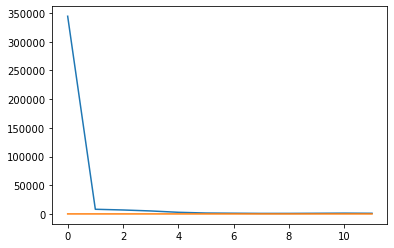

In [12]:
plt.plot(pretrain_model.history['loss'])
plt.plot(pretrain_model.history['val_0_unsup_loss'])

In [13]:
pretrain_model.save_model('./pretrain_model')  # load_model('./pretrain_model.zip')
tabnet_regressor.save_model('./tabnet_regressor_huber')  # load_model('./tabnet_regressor_huber.zip')

Successfully saved model at ./pretrain_model.zip
Successfully saved model at ./tabnet_regressor_huber.zip


'./tabnet_regressor_huber.zip'

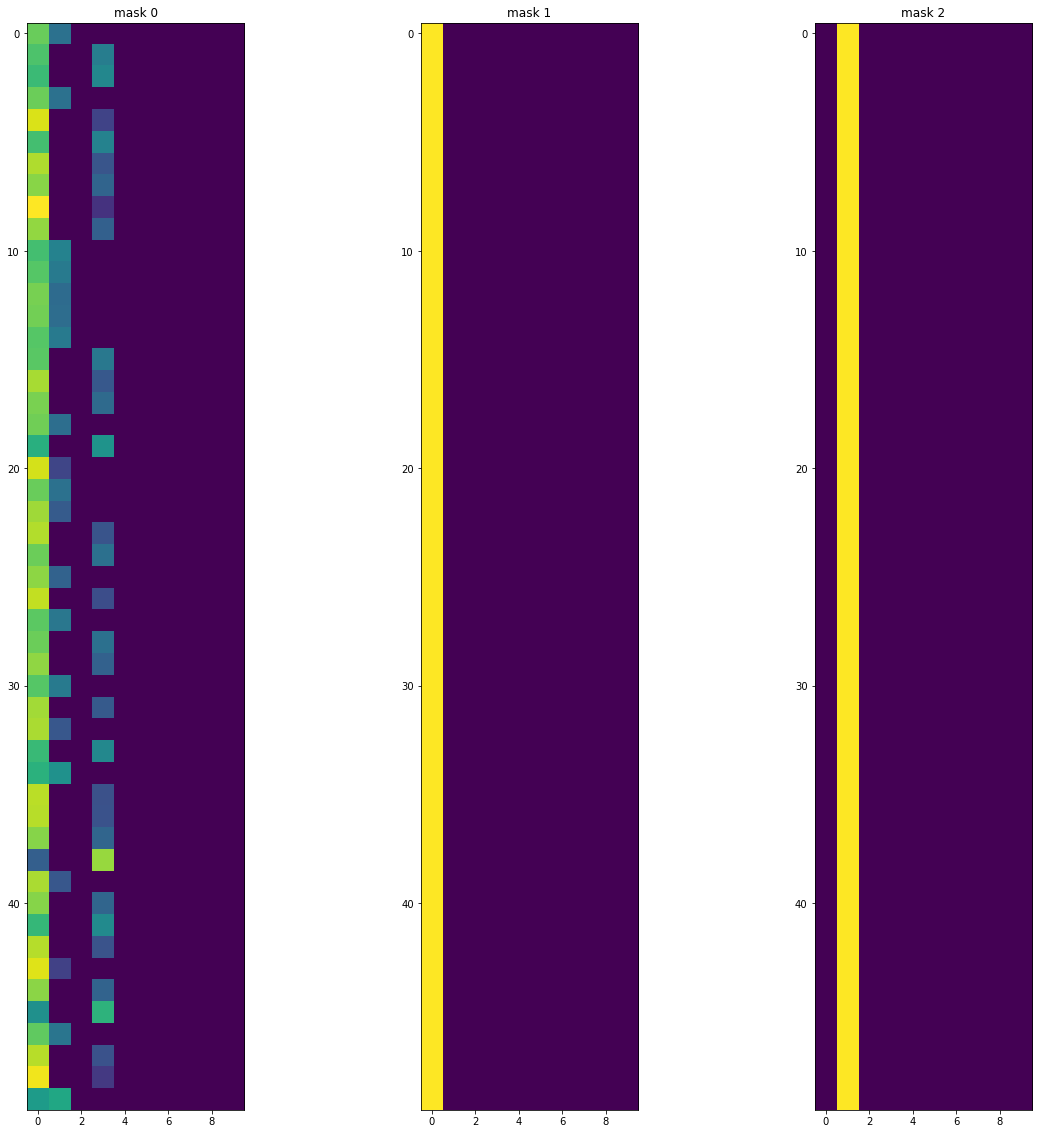

In [14]:
explain_matrix, masks = tabnet_regressor.explain(X_test)
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

## Visualizing store embeddings

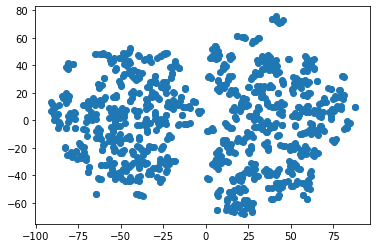

In [15]:
embeddings = \
(
    tabnet_regressor
    .network
    .embedder
    .embeddings[0](torch.arange(0, data.Store.nunique(), dtype=torch.int32))
    .detach()
)

tsne = TSNE(n_components=2, verbose=0, perplexity=4, init='pca')
scat = tsne.fit_transform(embeddings)
plt.figure(1)
plt.scatter(scat[:, 0], scat[:, 1])